WORK IN PROGRESS !

Up-to-date-version of EDA: https://drive.google.com/file/d/18vU4xSrogeSoXaLbFZ2qFoxRE72KTRnL/view?usp=sharing

# Imports

In [ ]:
#

In [ ]:
%%capture
! pip install lightning

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
#import torch.utils.data as data

import sys
import os

import pandas as pd
import numpy as np
import glob

import torch
#import pytorch


#import torchvision.models as models
#import lightning as L

import pytorch_lightning as L

import torch.nn as nn

from torchsummary import summary
from torchvision import datasets, transforms, models
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader, WeightedRandomSampler, Dataset

import cv2
import albumentations as A
#import albumentations.pytorch
from albumentations.pytorch import ToTensorV2
from pytorch_lightning.loggers.tensorboard import TensorBoardLogger
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning import Trainer





dev = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
torch.__version__

'2.4.1+cu121'

In [ ]:
#dev

In [ ]:
#!nvidia-smi

In [ ]:
##torch.cuda.get_device_capability()

In [ ]:
#torch.cuda.mem_get_info()

In [ ]:
NUM_WORKERS = os.cpu_count() # <- use all available CPU cores (this number can be tweaked through experimentation but generally more workers means faster dataloading from CPU to GPU)
NUM_WORKERS

2

In [ ]:
home_folder = '/content/gdrive/MyDrive/Colab Notebooks/Portfolio/DL_Mushrooms/'

The Python-file with the functions is at
https://drive.google.com/file/d/1K-CdoRhxXYcsDJZsSiX1ud70nLa0vmPT/view?usp=sharing

In [ ]:
%load_ext autoreload
%autoreload 2


sys.path.append(home_folder)
import mushfunc as mfunc


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Data

In [ ]:
%%capture

! mkdir ~/.kaggle
! cp /content/gdrive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d maysee/mushrooms-classification-common-genuss-images
! unzip -o mushrooms-classification-common-genuss-images

In [ ]:
!ls mushrooms/Mushrooms

Agaricus  Amanita  Boletus  Cortinarius  Entoloma  Hygrocybe  Lactarius  Russula  Suillus


In [ ]:
image_list = []
i=0
all_filepaths = glob.glob('mushrooms/Mushrooms/*/*.jpg', recursive=True)
for filepath in all_filepaths:
    mushroom_class = filepath.split("/")[-2]
    image_list.append((filepath, mushroom_class))

mushroom_df = pd.DataFrame(image_list, columns = ['filename', 'class'])


#all_filepaths.sort()
#all_filepaths[:10]

## EDA

In [ ]:
print('data shape: {}'.format(mushroom_df.shape))

data shape: (6714, 2)


In [ ]:
mushroom_classes = sorted(mushroom_df['class'].unique().tolist())

class_map = {}
for i, name in enumerate(mushroom_classes):
    class_map[name] = i

class_map

{'Agaricus': 0,
 'Amanita': 1,
 'Boletus': 2,
 'Cortinarius': 3,
 'Entoloma': 4,
 'Hygrocybe': 5,
 'Lactarius': 6,
 'Russula': 7,
 'Suillus': 8}

In [ ]:
mushroom_df['class_label'] = mushroom_df['class'].map(class_map)
mushroom_df

filename    class  class_label
0     mushrooms/Mushrooms/Russula/438_PDAjnJXeY1E.jpg  Russula            7
1     mushrooms/Mushrooms/Russula/326_aMHgLUn7KwM.jpg  Russula            7
2     mushrooms/Mushrooms/Russula/051_pW3j3Kbukas.jpg  Russula            7
3     mushrooms/Mushrooms/Russula/204_GfFiOeFtwzU.jpg  Russula            7
4     mushrooms/Mushrooms/Russula/741_oHNNaASNykM.jpg  Russula            7
...                                               ...      ...          ...
6709  mushrooms/Mushrooms/Amanita/443_1A-ek2yuX_s.jpg  Amanita            1
6710  mushrooms/Mushrooms/Amanita/312_Qqz-2C1I8qk.jpg  Amanita            1
6711  mushrooms/Mushrooms/Amanita/473_EkoyHA99K5w.jpg  Amanita            1
6712  mushrooms/Mushrooms/Amanita/663_zoxP_gipxhE.jpg  Amanita            1
6713  mushrooms/Mushrooms/Amanita/306_Z1m0PLRjbtY.jpg  Amanita            1

[6714 rows x 3 columns]

### Class Frequency

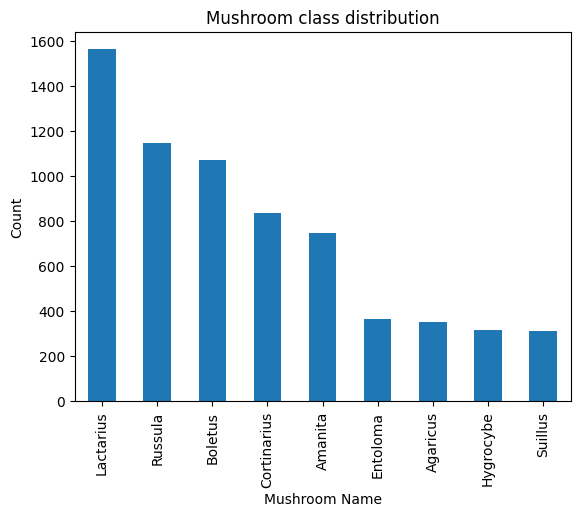

In [ ]:
import matplotlib.pyplot as plt

mushroom_df['class'].value_counts().plot(kind='bar')
plt.title('Mushroom class distribution')
plt.xlabel('Mushroom Name')
plt.ylabel('Count')
plt.show()

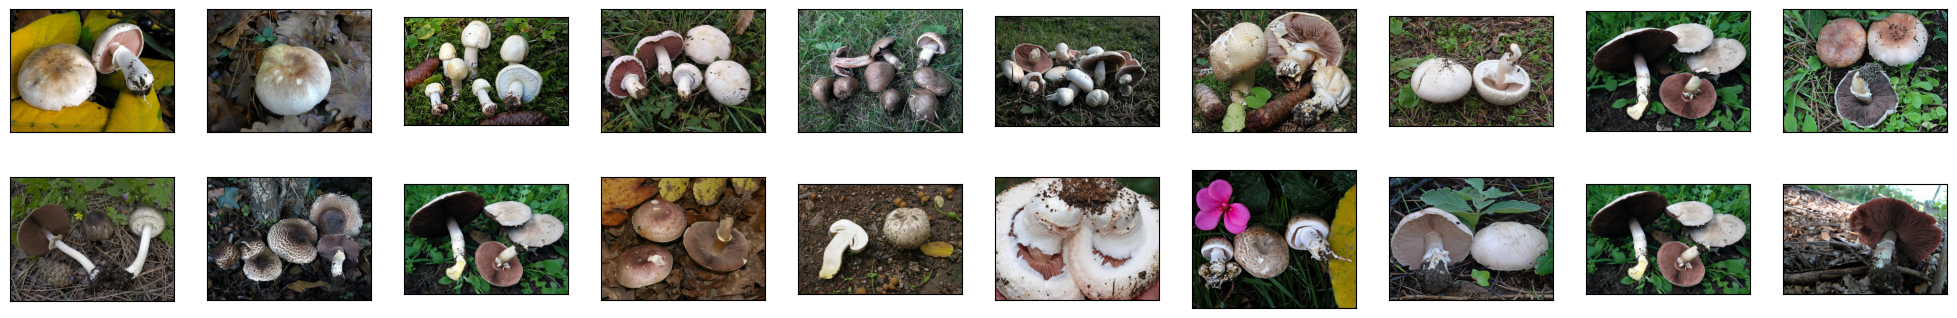

In [ ]:
import os
from PIL import Image

PATH_DATASETS = 'mushrooms/Mushrooms/Agaricus/'
fig = plt.figure(figsize=(25, 4))
# display 20 images
train_imgs = os.listdir(PATH_DATASETS)
np.random.seed(0)

for idx, img in enumerate(np.random.choice(train_imgs, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open(PATH_DATASETS + img)
    plt.imshow(im)
    #lab = labels.loc[labels['id'] == img.split('.')[0], 'label'].values[0]
    #ax.set_title(f'Label: {lab}')

## Test subsample

In [ ]:
def get_first_few_entries(df, column = 'class', n_entries = 5):
    names = df[column].unique()
    df_new = pd.DataFrame(columns=df.columns)
    #print(df_new)
    for name in names:
        first_rows = df.loc[df[column]==name][:n_entries]
        #print(first_rows)
        df_new = pd.concat([df_new, first_rows], axis=0)
    return df_new

first_entries = get_first_few_entries(mushroom_df, n_entries = 100)
first_entries.head(10)

filename    class class_label
0  mushrooms/Mushrooms/Russula/438_PDAjnJXeY1E.jpg  Russula           7
1  mushrooms/Mushrooms/Russula/326_aMHgLUn7KwM.jpg  Russula           7
2  mushrooms/Mushrooms/Russula/051_pW3j3Kbukas.jpg  Russula           7
3  mushrooms/Mushrooms/Russula/204_GfFiOeFtwzU.jpg  Russula           7
4  mushrooms/Mushrooms/Russula/741_oHNNaASNykM.jpg  Russula           7
5  mushrooms/Mushrooms/Russula/455_K6wzhsL2hEU.jpg  Russula           7
6  mushrooms/Mushrooms/Russula/396_vxteiV8es0s.jpg  Russula           7
7  mushrooms/Mushrooms/Russula/512_tHSRZSNQzrc.jpg  Russula           7
8  mushrooms/Mushrooms/Russula/097_vcRnfngKDrA.jpg  Russula           7
9  mushrooms/Mushrooms/Russula/286_le3-3FWFZc8.jpg  Russula           7

## Transform Experiments

Tensors have the format (Batch, Channel, Height, Width) while PIL Images have (Batch, height, width, channel). (https://forums.fast.ai/t/image-normalization-in-pytorch/7534/14)

In [ ]:
# https://saturncloud.io/blog/how-to-normalize-image-dataset-using-pytorch/

def get_mean_std(loader):
    # Compute the mean and standard deviation of all pixels in the dataset
    num_pixels = 0
    mean = 0.0
    std = 0.0
    for images, _ in loader:
        #print(images.shape)
        batch_size, num_channels, height, width = images.shape
        num_pixels += batch_size * height * width
        mean += images.mean(axis=(0, 2, 3))#.sum()
        std += images.std(axis=(0, 2, 3))#.sum()

    mean /= num_pixels
    std /= num_pixels

    return mean, std

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])



In [ ]:
%%time

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

data_set=datasets.ImageFolder(root='mushrooms/Mushrooms',transform=data_transforms)
batch_size = 32
loader = DataLoader(data_set, batch_size=batch_size, shuffle=True, num_workers=16)


mean, std = get_mean_std(loader)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


CPU times: user 10.2 s, sys: 2.21 s, total: 12.5 s
Wall time: 1min 28s


In [ ]:
mean, std

(tensor([2.4397e-07, 2.3043e-07, 1.7545e-07]),
 tensor([1.5536e-07, 1.4111e-07, 1.3903e-07]))

# Transforms

In [ ]:
%%time

# https://forums.fast.ai/t/image-normalization-in-pytorch/7534/10

#transform = transforms.Compose([
#    transforms.ToPILImage(),
#    transforms.ToTensor()
#])

dataloader = torch.utils.data.DataLoader(data_set, batch_size=batch_size, shuffle=False, num_workers=4)

pop_mean = []
pop_std0 = []
pop_std1 = []
for i, data in enumerate(dataloader, 0):
    # shape (batch_size, 3, height, width)
    #print(data[0].shape)
    numpy_image = data[0].numpy()

    # shape (3,)
    batch_mean = np.mean(numpy_image, axis=(0,2,3))
    batch_std0 = np.std(numpy_image, axis=(0,2,3))
    batch_std1 = np.std(numpy_image, axis=(0,2,3), ddof=1)

    pop_mean.append(batch_mean)
    pop_std0.append(batch_std0)
    pop_std1.append(batch_std1)

# shape (num_iterations, 3) -> (mean across 0th axis) -> shape (3,)
pop_mean = np.array(pop_mean).mean(axis=0)
pop_std0 = np.array(pop_std0).mean(axis=0)
pop_std1 = np.array(pop_std1).mean(axis=0)

print('pop_mean: ', pop_mean)
print('pop_std0: ', pop_std0)
print('pop_std1: ', pop_std1)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


pop_mean:  [0.39140812 0.36965358 0.28144658]
pop_std0:  [0.24785632 0.22527446 0.2208299 ]
pop_std1:  [0.24785644 0.22527452 0.22083   ]
CPU times: user 7.04 s, sys: 2.19 s, total: 9.23 s
Wall time: 1min 15s


Calculations above were for comparison with the ImageNet normalizations, which we will use in the following:

In [ ]:
# ImageNet parametes for transforms

imnet_mean = [0.485, 0.456, 0.406]    # rgb
imnet_std = [0.229, 0.224, 0.225]

In [ ]:
# lightning style
transform=transforms.Compose([
        #transforms.RandomRotation(10),      # rotate +/- 10 degrees
        #transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize(imnet_mean,
                             imnet_std)
])

Basic tranform:
   - resize shorter axis to model axis length, cut out central range= model axis length along other axis

Data augmentations:
   - rotate
   - flip horizontally/vertically
   - modify color and brightness
   - random cut-outs resized to model axis length

In [ ]:
# albumentation style - what I will use here

train_augmentations = A.Compose([
    A.Rotate(limit = 45),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Posterize(8,p=0.2),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
    A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    #A.SmallestMaxSize(max_size=224),
    A.RandomResizedCrop(224, 224),
    A.Normalize(mean=imnet_mean, # ImageNet Mean
                std=imnet_std   # ImageNet Std
               ),
    ToTensorV2()
])

basic_transform = A.Compose([
    A.SmallestMaxSize(max_size=224),
    A.CenterCrop(height=224, width=224),
    A.Normalize(mean=imnet_mean, # ImageNet Mean
                std=imnet_std   # ImageNet Std
               ),
    ToTensorV2()

])

## Dataset

'The standard workflow would be to apply the random transformations inside the Dataset.__getitem__ method on each loaded (original) sample. This would create a new, augmented sample in each batch and you could still keep the original dataset small.' ptrblck on data augmentation https://discuss.pytorch.org/t/making-additional-data-with-data-augmentation-using-pytorch/190560/3

### visualize augmentation

In [ ]:
%reload_ext autoreload

labels = mushroom_df['class_label'].tolist()
images_filepaths = mushroom_df['filename'].tolist()


new_dataset = mfunc.MushroomsDataset(images_filepaths=images_filepaths,
                               labels = labels,
                               transform=train_augmentations)

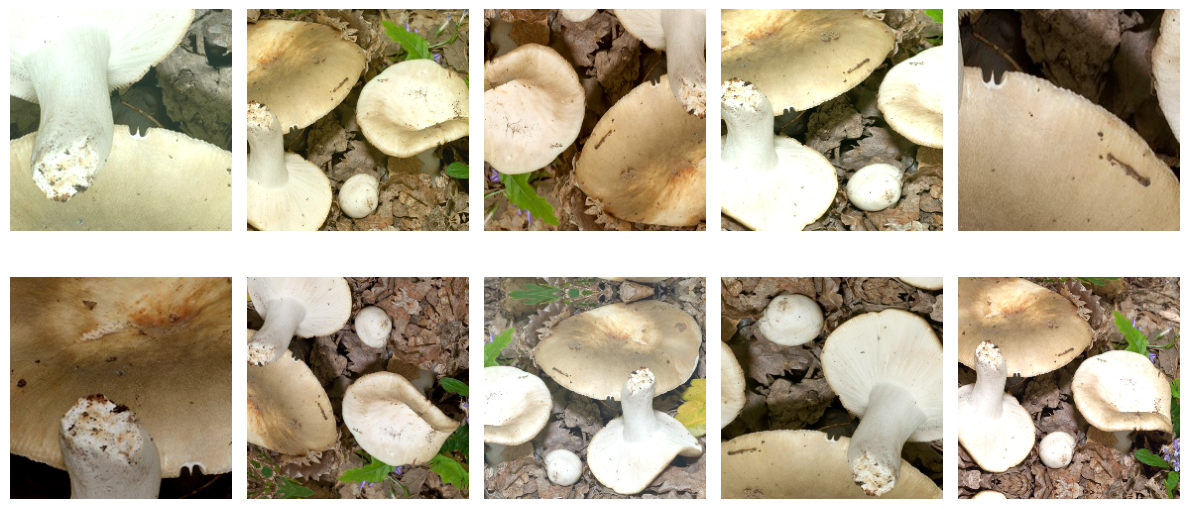

In [ ]:
%reload_ext autoreload

mfunc.visualize_augmentations(new_dataset)

## DataModule

In [ ]:
%reload_ext autoreload

#train_files, val_files, test_files = mfunc.split_data_from_path_df(mushroom_df)

In [ ]:
%reload_ext autoreload

test = mfunc.MushroomDataModule(data_df = mushroom_df,
                 augmentations = train_augmentations,
                 basic_transforms = basic_transform)
test.setup() #.train_dataset[:5],

## batchwise image grids

In [ ]:
traindatal=test.train_dataloader()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
from torchvision.utils import make_grid
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


images = []
labels = []
for images_batch, labels_batch in traindatal:
    images.append(images_batch)
    labels.append(labels_batch)

In [ ]:
#ax.imshow(data)
#for i in range(data.shape[0]):
#    for j in range(data.shape[1]):
#        ax.text(j, i, "{:.2f}".format(data[i,j]), ha="center", va="center")
#

''

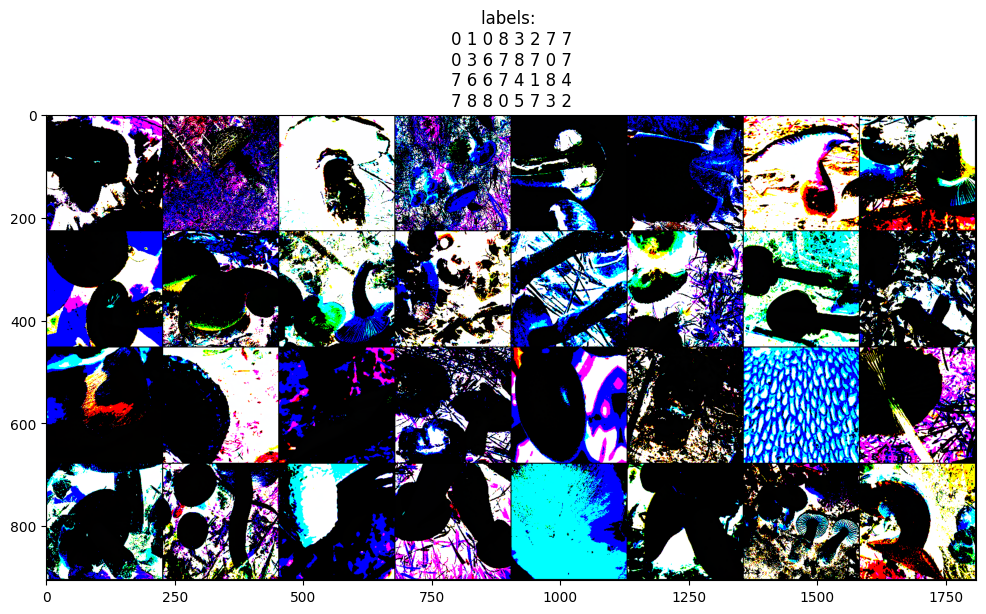

In [ ]:
%%time

BATCH_SIZE = 32
nrow = 8
im=make_grid(images[11],nrow=nrow)
lab = labels[11]

ncol = int(BATCH_SIZE/nrow)

labelgrid = []
for col in range(ncol):
    if col == ncol - 1:
        labelrow = [str(int(labl)) for labl in lab[col*nrow :]]
    else:
        labelrow = [str(int(labl)) for labl in lab[col*nrow : col*nrow + 8]]
    labelgrid.append(' '.join(labelrow))


title = 'labels: \n'+ '\n'.join(labelgrid)

plt.figure(figsize=(12,12))

transp = np.transpose(im.numpy(),(1,2,0))
plt.imshow(transp.astype('uint8'))
plt.title(title)

;

#for i in range(transp.shape[0]):
#    for j in range(transp.shape[1]):
#        ax.text(j, i, "{:.2f}".format(lab[i,j]), ha="center", va="center")

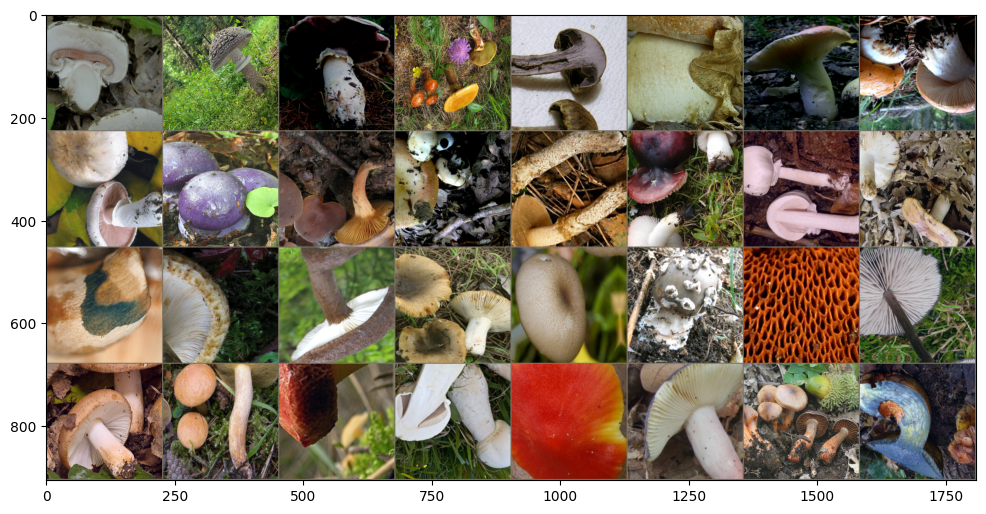

In [ ]:
inv_normalize=transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225],
                                   std=[1/0.229,1/0.224,1/0.225])
im=inv_normalize(im)

plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))
